# Min Norm Solution for Bleed Removal

In [1]:
import numpy as np
import numpy.linalg as linalg

In [17]:
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt

#### Loading Bleed Sources

In [49]:
#Music Delta - Hendrix/
#Hollow Ground - Left Blind

In [4]:
#os.listdir('/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/train/')

In [107]:
bleed_path = '/home/rajesh/Desktop/MoreBleed/Music Delta - Hendrix/'
bvocals, fs = lb.load(bleed_path+'vocals.wav')
bbass, fs = lb.load(bleed_path+'bass.wav')
bdrums, fs = lb.load(bleed_path+'drums.wav')
bother, fs = lb.load(bleed_path+'other.wav')

#### Loading True Sources

In [108]:
clean_path = '/home/rajesh/Desktop/Datasets/musdb18hq/train/Music Delta - Hendrix/'
vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

In [109]:
if len(bbass) > len(bass):
    n = len(bass)
else:
    n = len(bbass)

In [110]:
R = np.array([bvocals[:n], bbass[:n], bdrums[:n], bother[:n]]) #two min
R.shape

(4, 437559)

In [111]:
S = np.array([vocals[:n], bass[:n], drums[:n], other[:n]])
S.shape

(4, 437559)

#### Min Norm Solution

In [112]:
def leastnormsoln(r, s):
    b = np.array([r-s]).T
    A = np.array([[s[1], s[2], s[3], 0, 0 ,0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, s[0], s[2], s[3], 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, s[0], s[1], s[3], 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, s[0], s[1], s[2]]])
    soln, residual, rank, singular = linalg.lstsq(A, b, rcond=-1)
    return np.array([[1, soln[0][0], soln[1][0], soln[2][0]],
                     [soln[3][0], 1, soln[4][0], soln[5][0]],
                     [soln[6][0], soln[7][0], 1, soln[8][0]],
                     [soln[9][0], soln[10][0], soln[11][0], 1]])

In [113]:
lmda = []
for i in range(R.shape[1]):
    r = R[:, i]
    s = S[:, i]
    lmda.append(leastnormsoln(r, s))

In [114]:
lmda[0]

array([[ 1.        ,  0.11436704, -0.08459189,  0.03726413],
       [-0.14808077,  1.        ,  0.72059239, -0.31743287],
       [ 0.1454642 ,  0.95701619,  1.        ,  0.31182387],
       [ 0.00147583,  0.00970953, -0.00718168,  1.        ]])

In [120]:
15*22050, 140*22050

(330750, 3087000)

In [121]:
avg = np.average(lmda[0:330750], axis=0)
avg

array([[1.        , 0.59512247, 0.35804433, 0.34035071],
       [0.45519196, 1.        , 0.42535759, 0.4162051 ],
       [0.4007661 , 0.58128202, 1.        , 0.31275027],
       [0.3909633 , 0.56812139, 0.34010266, 1.        ]])

#### Getting Back Sources (Lambda Inverse)

In [115]:
def predict(r, l):
    lambda_inv = linalg.inv(l)
    soln = np.dot(lambda_inv,r)
    return soln

In [122]:
coln_soln = []
for i in range(R.shape[1]):
    r = R[:, i]
    l = avg #lmda[i]
    coln_soln.append(predict(r, l))

In [123]:
unbleeded = np.array(coln_soln).T

In [124]:
unbleed_vocal = unbleeded[0]
unbleed_bass = unbleeded[1]
unbleed_drum = unbleeded[2]
unbleed_other = unbleeded[3]

In [125]:
sf.write('/home/rajesh/Desktop/cleaned_vocal.wav', unbleed_vocal, fs)
sf.write('/home/rajesh/Desktop/cleaned_bass.wav', unbleed_bass, fs)
sf.write('/home/rajesh/Desktop/cleaned_drum.wav', unbleed_drum, fs)
sf.write('/home/rajesh/Desktop/cleaned_other.wav', unbleed_other, fs)

In [44]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [45]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [46]:
len(vocals), len(unbleed_vocal)

(437559, 437559)

In [47]:
v_sdr = compute_sdr(vocals[:437559], unbleed_vocal, fs)
b_sdr = compute_sdr(bass[:437559], unbleed_bass, fs)
d_sdr = compute_sdr(drums[:437559], unbleed_drum, fs)
o_sdr = compute_sdr(other[:437559], unbleed_other, fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(17.620198619704446,
 16.342885021458613,
 18.64509684017519,
 21.27312815229399,
 14.219684464889994)

#### Time domain plots

In [126]:
def norm(A):
    forb = linalg.norm(A, ord='fro')
    l1 = linalg.norm(A, ord=1)
    l2 = linalg.norm(A, ord=2)
    return l1, l2, forb

In [127]:
l1, l2, forb = [], [], []
for i in lmda:
    l_1, l_2, forbn = norm(i)
    l1.append(l_1)
    l2.append(l_2)
    forb.append(forbn)

In [128]:
x = np.arange(len(l1))/fs

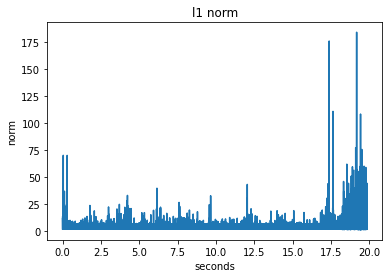

In [129]:
plt.plot(x, l1)
plt.title('l1 norm')
plt.xlabel('seconds')
plt.ylabel('norm')
plt.savefig('/home/rajesh/Desktop/l1.png', dpi = 1000)
plt.show()

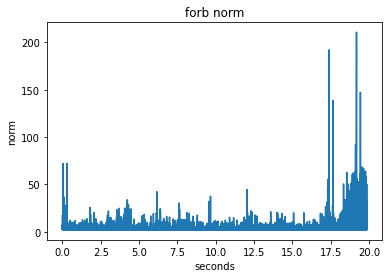

In [130]:
plt.plot(x, forb)
plt.title('forb norm')
plt.xlabel('seconds')
plt.ylabel('norm')
plt.savefig('/home/rajesh/Desktop/forb.png', dpi = 1000)
plt.show()

#### Difference Histograms

In [37]:
import itertools
from matplotlib import pyplot as plt

In [63]:
def norm(A):
    forb = linalg.norm(A, ord='fro')
    l1 = linalg.norm(A, ord=1)
    l2 = linalg.norm(A, ord=2)
    return l1, l2, forb

In [42]:
lamda_comb = list(itertools.combinations(lmda[:1000], 2))

In [43]:
diff = []
for everyblock in lamda_comb:
    diff.append(everyblock[0]-everyblock[1])

In [44]:
l1, l2, forb = [], [], []
for i in range(len(diff)):
    l_1, l_2, forbn = norm(diff[i])
    l1.append(l_1)
    l2.append(l_2)
    forb.append(forbn)

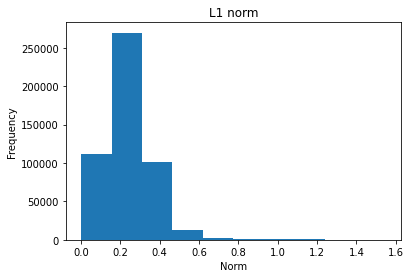

In [45]:
plt.hist(l1)
plt.title('L1 norm')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.show()

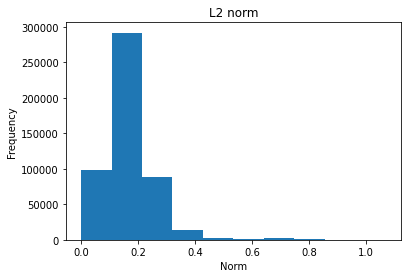

In [46]:
plt.hist(l2)
plt.title('L2 norm')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.show()

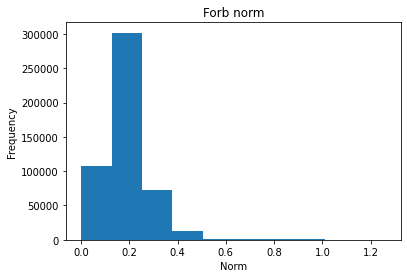

In [47]:
plt.hist(forb)
plt.title('Forb norm')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.show()

### Add more bleed

In [102]:
bleed_path = '/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/train/Music Delta - Hendrix/'

In [103]:
from pydub import AudioSegment

In [104]:
factor = 0 #Volume reduction in dB

In [105]:
def overlay_files(f1, f2, f3, f4):
    y1 = f1.overlay(f2)
    y2 = y1.overlay(f3)
    y3 = y2.overlay(f4)
    return y3

In [106]:
folder = bleed_path
vocals = AudioSegment.from_file(os.path.join(folder, "vocals.wav"), "wav")
drums = AudioSegment.from_file(os.path.join(folder, "drums.wav"), "wav")
bass = AudioSegment.from_file(os.path.join(folder, "bass.wav"), "wav")
other = AudioSegment.from_file(os.path.join(folder, "other.wav"), "wav")

vocals_mmm = vocals-factor
drums_mmm = drums-factor
bass_mmm = bass-factor
other_mmm = other-factor

vocals_bleeded = overlay_files(vocals, drums_mmm, bass_mmm, other_mmm)
drums_bleeded = overlay_files(drums, vocals_mmm, bass_mmm, other_mmm)
bass_bleeded = overlay_files(bass, drums_mmm, vocals_mmm, other_mmm)
other_bleeded = overlay_files(other, drums_mmm, bass_mmm, vocals_mmm)

curr_path = "/home/rajesh/Desktop/"
vocals_bleeded.export(curr_path+"/vocals.wav", "wav")
drums_bleeded.export(curr_path+"/drums.wav", "wav")
bass_bleeded.export(curr_path+"/bass.wav", "wav")
other_bleeded.export(curr_path+"/other.wav", "wav")

<_io.BufferedRandom name='/home/rajesh/Desktop//other.wav'>